# Test Neuromancer DPC examples - reference tracking for nonlinear ODE

example is taken from here: https://colab.research.google.com/github/pnnl/neuromancer/blob/master/examples/control/Part_3_ref_tracking_ODE.ipynb

**Purpose:** play around with weights etc. to learn what's the effect


## 1) run code from the example notebook

In [1]:
import torch
import torch.nn as nn
import numpy as np

import neuromancer.psl as psl
from neuromancer.system import Node, System#, SystemPreview
from neuromancer.modules import blocks
from neuromancer.modules.activations import activations
from neuromancer.dataset import DictDataset
from neuromancer.constraint import variable
from neuromancer.loss import PenaltyLoss
from neuromancer.problem import Problem
from neuromancer.trainer import Trainer
from neuromancer.dynamics import ode, integrators
from neuromancer.plot import pltCL, pltPhase
from copy import deepcopy

In [2]:
# ground truth system model
gt_model = psl.nonautonomous.TwoTank()
# sampling rate
ts = gt_model.params[1]['ts']
# problem dimensions
nx = gt_model.nx    # number of states
nu = gt_model.nu    # number of control inputs
nref = nx           # number of references
# constraints bounds
umin = 0
umax = 1.
xmin = 0
xmax = 1.

In [3]:
nsteps = 30  # prediction horizon
n_samples = 2000    # number of sampled scenarios

#  sampled references for training the policy
list_refs = [torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
ref = torch.cat(list_refs)
batched_ref = ref.reshape([n_samples, nsteps+1, nref])
# Training dataset
train_data = DictDataset({'x': torch.rand(n_samples, 1, nx),   # sampled initial conditions of states
                          'r': batched_ref}, name='train')

# sampled references for development set
list_refs = [torch.rand(1, 1)*torch.ones(nsteps+1, nref) for k in range(n_samples)]
ref = torch.cat(list_refs)
batched_ref = ref.reshape([n_samples, nsteps+1, nref])
# Development dataset
dev_data = DictDataset({'x': torch.rand(n_samples, 1, nx),    # sampled initial conditions of states
                        'r': batched_ref}, name='dev')

# torch dataloaders
batch_size = 200
train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,
                                           collate_fn=train_data.collate_fn,
                                           shuffle=False)
dev_loader = torch.utils.data.DataLoader(dev_data, batch_size=batch_size,
                                         collate_fn=dev_data.collate_fn,
                                         shuffle=False)

In [4]:
# white-box ODE model with no-plant model mismatch
two_tank_ode = ode.TwoTankParam()                   # ODE system equations implemented in PyTorch
two_tank_ode.c1 = nn.Parameter(torch.tensor(gt_model.c1), requires_grad=False)
two_tank_ode.c2 = nn.Parameter(torch.tensor(gt_model.c2), requires_grad=False)

# integrate continuous time ODE
integrator = integrators.RK4(two_tank_ode, h=torch.tensor(ts))   # using 4th order runge kutta integrator

In [5]:
# symbolic system model
model = Node(integrator, ['x', 'u'], ['x'], name='model')

# neural net control policy with hard control action bounds
net = blocks.MLP_bounds(insize=nx + nref, outsize=nu, hsizes=[32, 32],
                    nonlin=activations['gelu'], min=umin, max=umax)
policy = Node(net, ['x', 'r'], ['u'], name='policy')

# closed-loop system model
cl_system = System([policy, model], nsteps=nsteps)
cl_system1 = deepcopy(cl_system)
cl_system2 = deepcopy(cl_system)

## Question: what happens if I change the weights on the constraints?

### 1st: original formulation:

In [6]:
# variables
x = variable('x')
ref = variable("r")
# objectives
regulation_loss = 5. * ((x == ref) ^ 2)  # target posistion
# constraints
state_lower_bound_penalty = 10.*(x > xmin)
state_upper_bound_penalty = 10.*(x < xmax)
terminal_lower_bound_penalty = 10.*(x[:, [-1], :] > ref-0.01)
terminal_upper_bound_penalty = 10.*(x[:, [-1], :] < ref+0.01)
# objectives and constraints names for nicer plot
regulation_loss.name = 'state_loss'
state_lower_bound_penalty.name = 'x_min'
state_upper_bound_penalty.name = 'x_max'
terminal_lower_bound_penalty.name = 'y_N_min'
terminal_upper_bound_penalty.name = 'y_N_max'
# list of constraints and objectives
objectives = [regulation_loss]
constraints = [
    state_lower_bound_penalty,
    state_upper_bound_penalty,
    terminal_lower_bound_penalty,
    terminal_upper_bound_penalty,
]
# create constrained optimization loss
loss = PenaltyLoss(objectives, constraints)

### 2nd different weight on the state upper/lower penalty loss

factor 1000 instead of 10

In [7]:
state_lower_bound_penalty1 = 1000.*(x > xmin)
state_upper_bound_penalty1 = 1000.*(x < xmax)
state_lower_bound_penalty1.name = 'x_min'
state_upper_bound_penalty1.name = 'x_max'

constraints1 = [
    state_lower_bound_penalty1,
    state_upper_bound_penalty1,
    terminal_lower_bound_penalty,
    terminal_upper_bound_penalty,
]
# create constrained optimization loss
loss1 = PenaltyLoss(objectives, constraints1)

### 3rd different weight on the state upper/lower penalty loss

factor 0.1 instead of 10

In [8]:
state_lower_bound_penalty2 = 1/10.*(x > xmin)
state_upper_bound_penalty2 = 1/10.*(x < xmax)
state_lower_bound_penalty2.name = 'x_min'
state_upper_bound_penalty2.name = 'x_max'

constraints2 = [
    state_lower_bound_penalty2,
    state_upper_bound_penalty2,
    terminal_lower_bound_penalty,
    terminal_upper_bound_penalty,
]
# create constrained optimization loss
loss2 = PenaltyLoss(objectives, constraints2)

### formulate the 3 problems and solve:

In [ ]:
problem = Problem([cl_system], loss)
problem1 = Problem([cl_system1], loss1)
problem2 = Problem([cl_system2], loss2)


optimizer = torch.optim.AdamW(problem.parameters(), lr=0.002)
optimizer1 = torch.optim.AdamW(problem1.parameters(), lr=0.002)
optimizer2 = torch.optim.AdamW(problem2.parameters(), lr=0.002)

trainer = Trainer(
    problem,
    train_loader, dev_loader,
    optimizer=optimizer,
    epochs=100,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=50,
)

trainer1 = Trainer(
    problem1,
    train_loader, dev_loader,
    optimizer=optimizer1,
    epochs=100,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=50,
)

trainer2 = Trainer(
    problem2,
    train_loader, dev_loader,
    optimizer=optimizer2,
    epochs=100,
    train_metric='train_loss',
    eval_metric='dev_loss',
    warmup=50,
)

best_model = trainer.train()
trainer.model.load_state_dict(best_model)

best_model1 = trainer1.train()
trainer1.model.load_state_dict(best_model1)

best_model2 = trainer2.train()
trainer2.model.load_state_dict(best_model2)

/home/martgro1/pot_neuromancer_for_ocp/.venv/lib/python3.10/site-packages/torch/cuda/__init__.py:829: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


epoch: 0  train_loss: 4.112015247344971
epoch: 1  train_loss: 3.682724714279175
epoch: 2  train_loss: 3.306091785430908
epoch: 3  train_loss: 2.895296812057495
epoch: 4  train_loss: 2.403454542160034
epoch: 5  train_loss: 1.8995029926300049
epoch: 6  train_loss: 1.5794146060943604
epoch: 7  train_loss: 1.4401092529296875
epoch: 8  train_loss: 1.3314478397369385
epoch: 9  train_loss: 1.2361068725585938
epoch: 10  train_loss: 1.16606867313385
epoch: 11  train_loss: 1.1067988872528076
epoch: 12  train_loss: 1.0614194869995117
epoch: 13  train_loss: 1.0218297243118286
epoch: 14  train_loss: 0.9904805421829224
epoch: 15  train_loss: 0.9622170329093933
epoch: 16  train_loss: 0.9366276860237122
epoch: 17  train_loss: 0.9131408929824829
epoch: 18  train_loss: 0.8911749720573425
epoch: 19  train_loss: 0.8714078068733215
epoch: 20  train_loss: 0.8534839749336243
epoch: 21  train_loss: 0.8371843099594116
epoch: 22  train_loss: 0.8218662142753601
epoch: 23  train_loss: 0.8079469799995422
epoch: 24

<All keys matched successfully>

In [10]:
# Creating the test data
nsteps = 1000
step_length = 250
# generate reference
np_refs = psl.signals.step(nsteps + 1, 1, min=xmin, max=xmax, randsteps=4, rng=np.random.default_rng(20))
R = torch.tensor(np_refs, dtype=torch.float32).reshape(1, nsteps+1, 1)
torch_ref = torch.cat([R, R], dim=-1)
# generate initial data for closed loop simulation
data = {'x': torch.rand(1, 1, nx, dtype=torch.float32),
        'r': torch_ref}

# constraints bounds
Umin = umin * np.ones([nsteps, nu])
Umax = umax * np.ones([nsteps, nu])
Xmin = xmin * np.ones([nsteps+1, nx])
Xmax = xmax * np.ones([nsteps+1, nx])

DPC with original weights on constraints


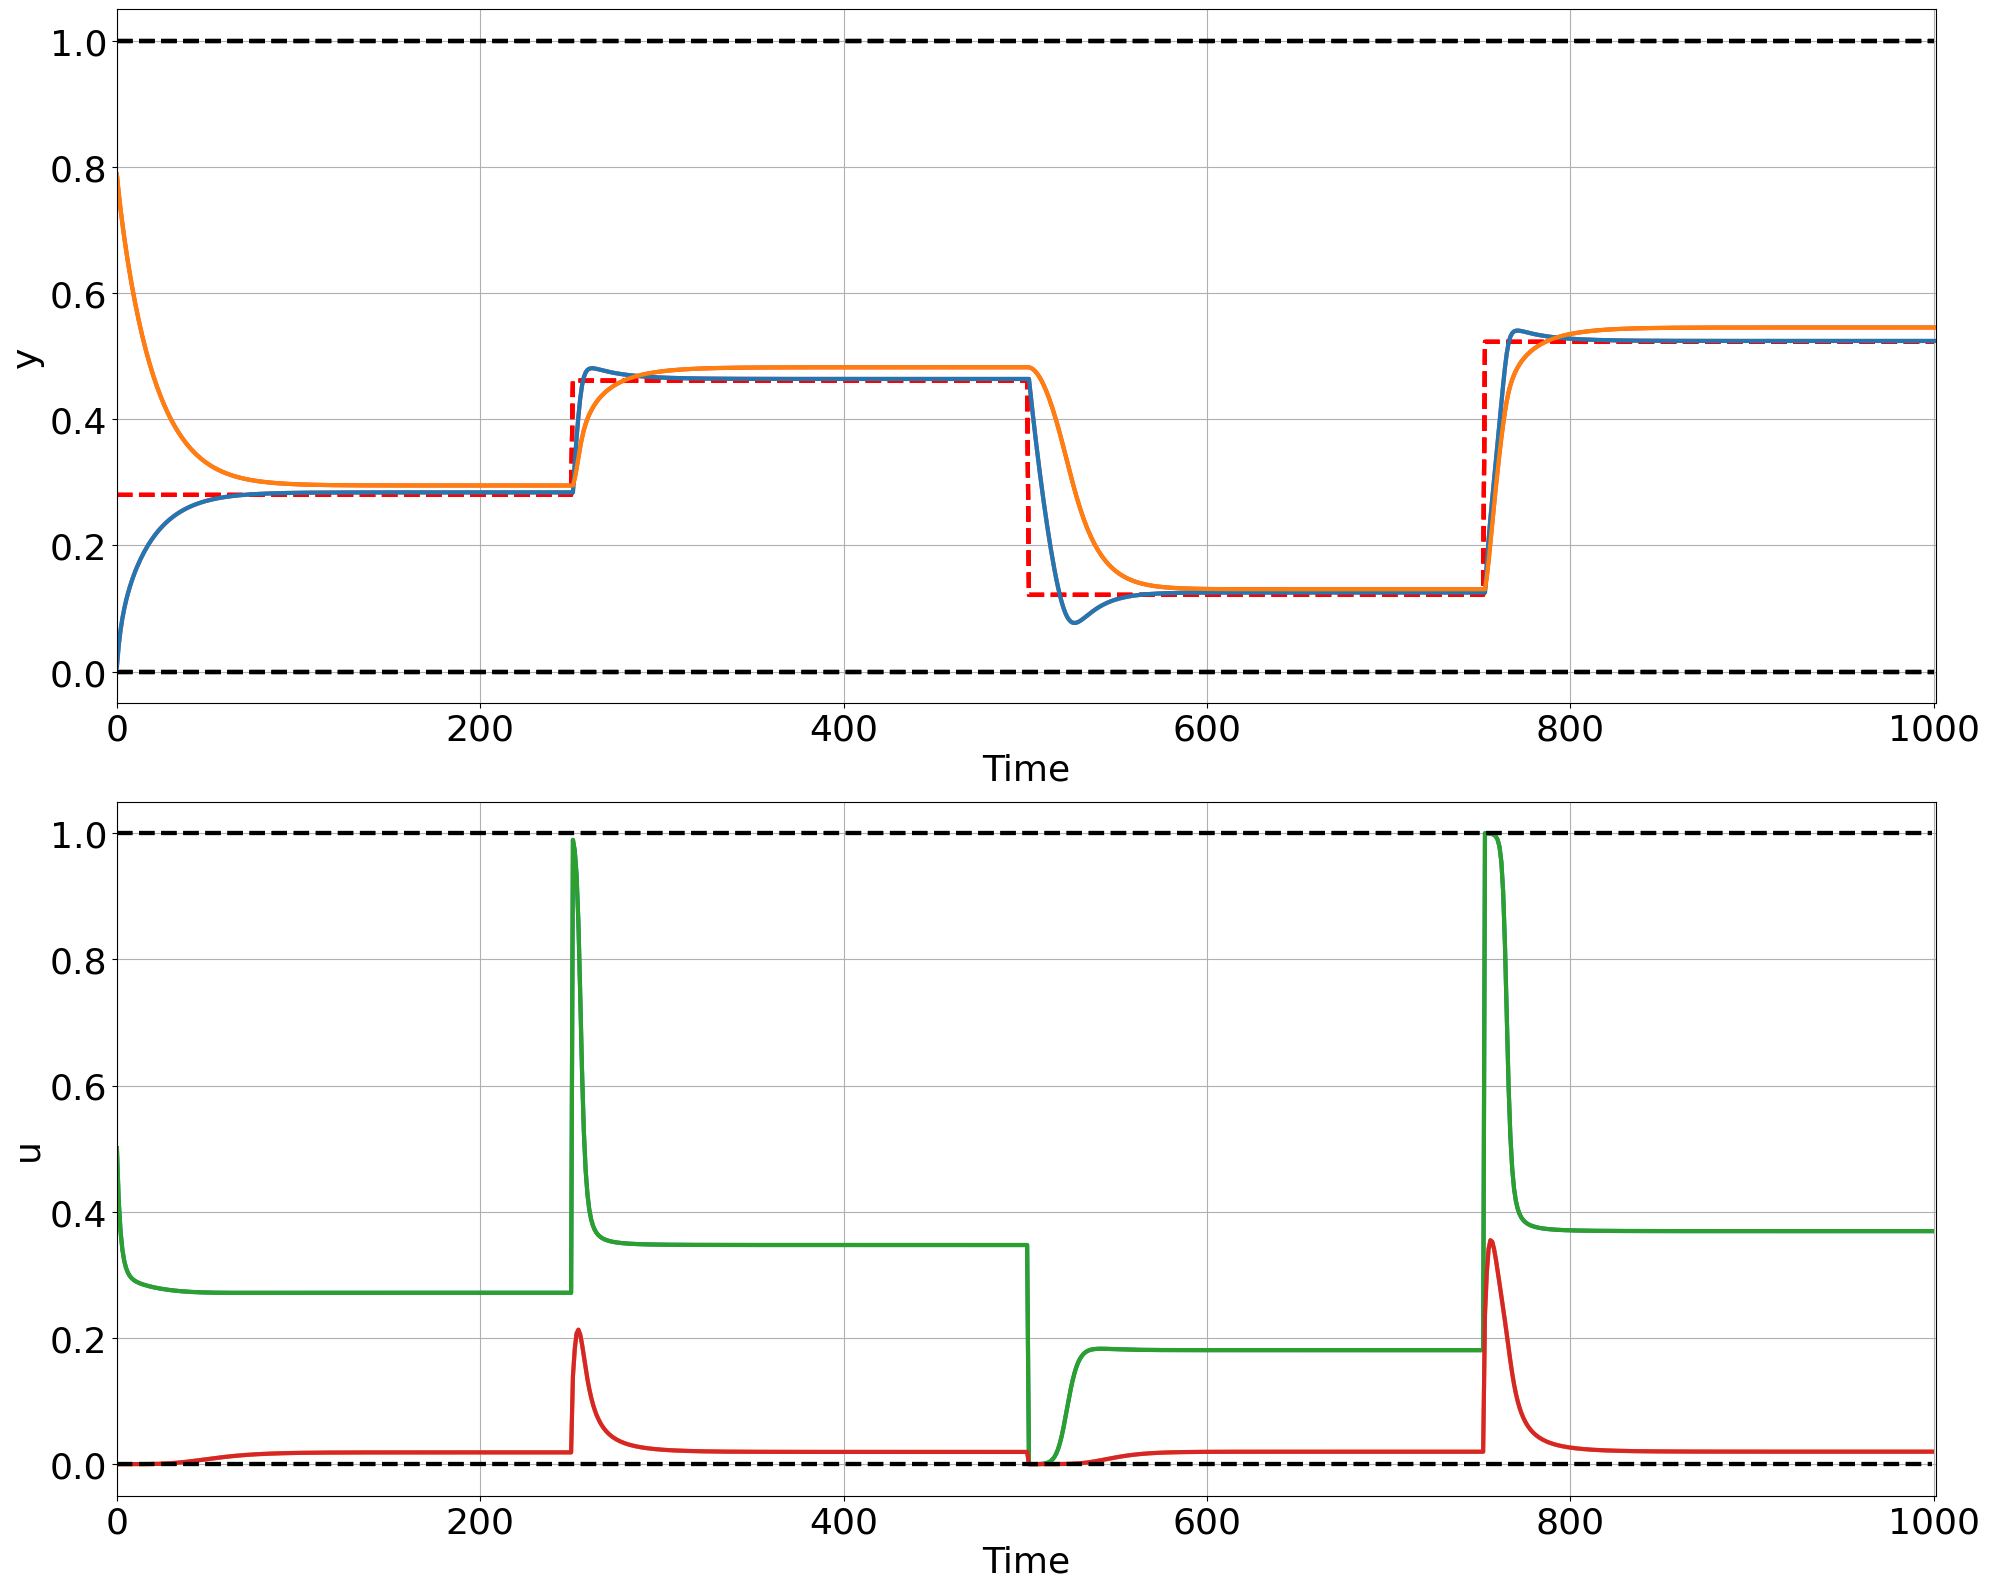

DPC with higher weights on constraints


<Figure size 640x480 with 0 Axes>

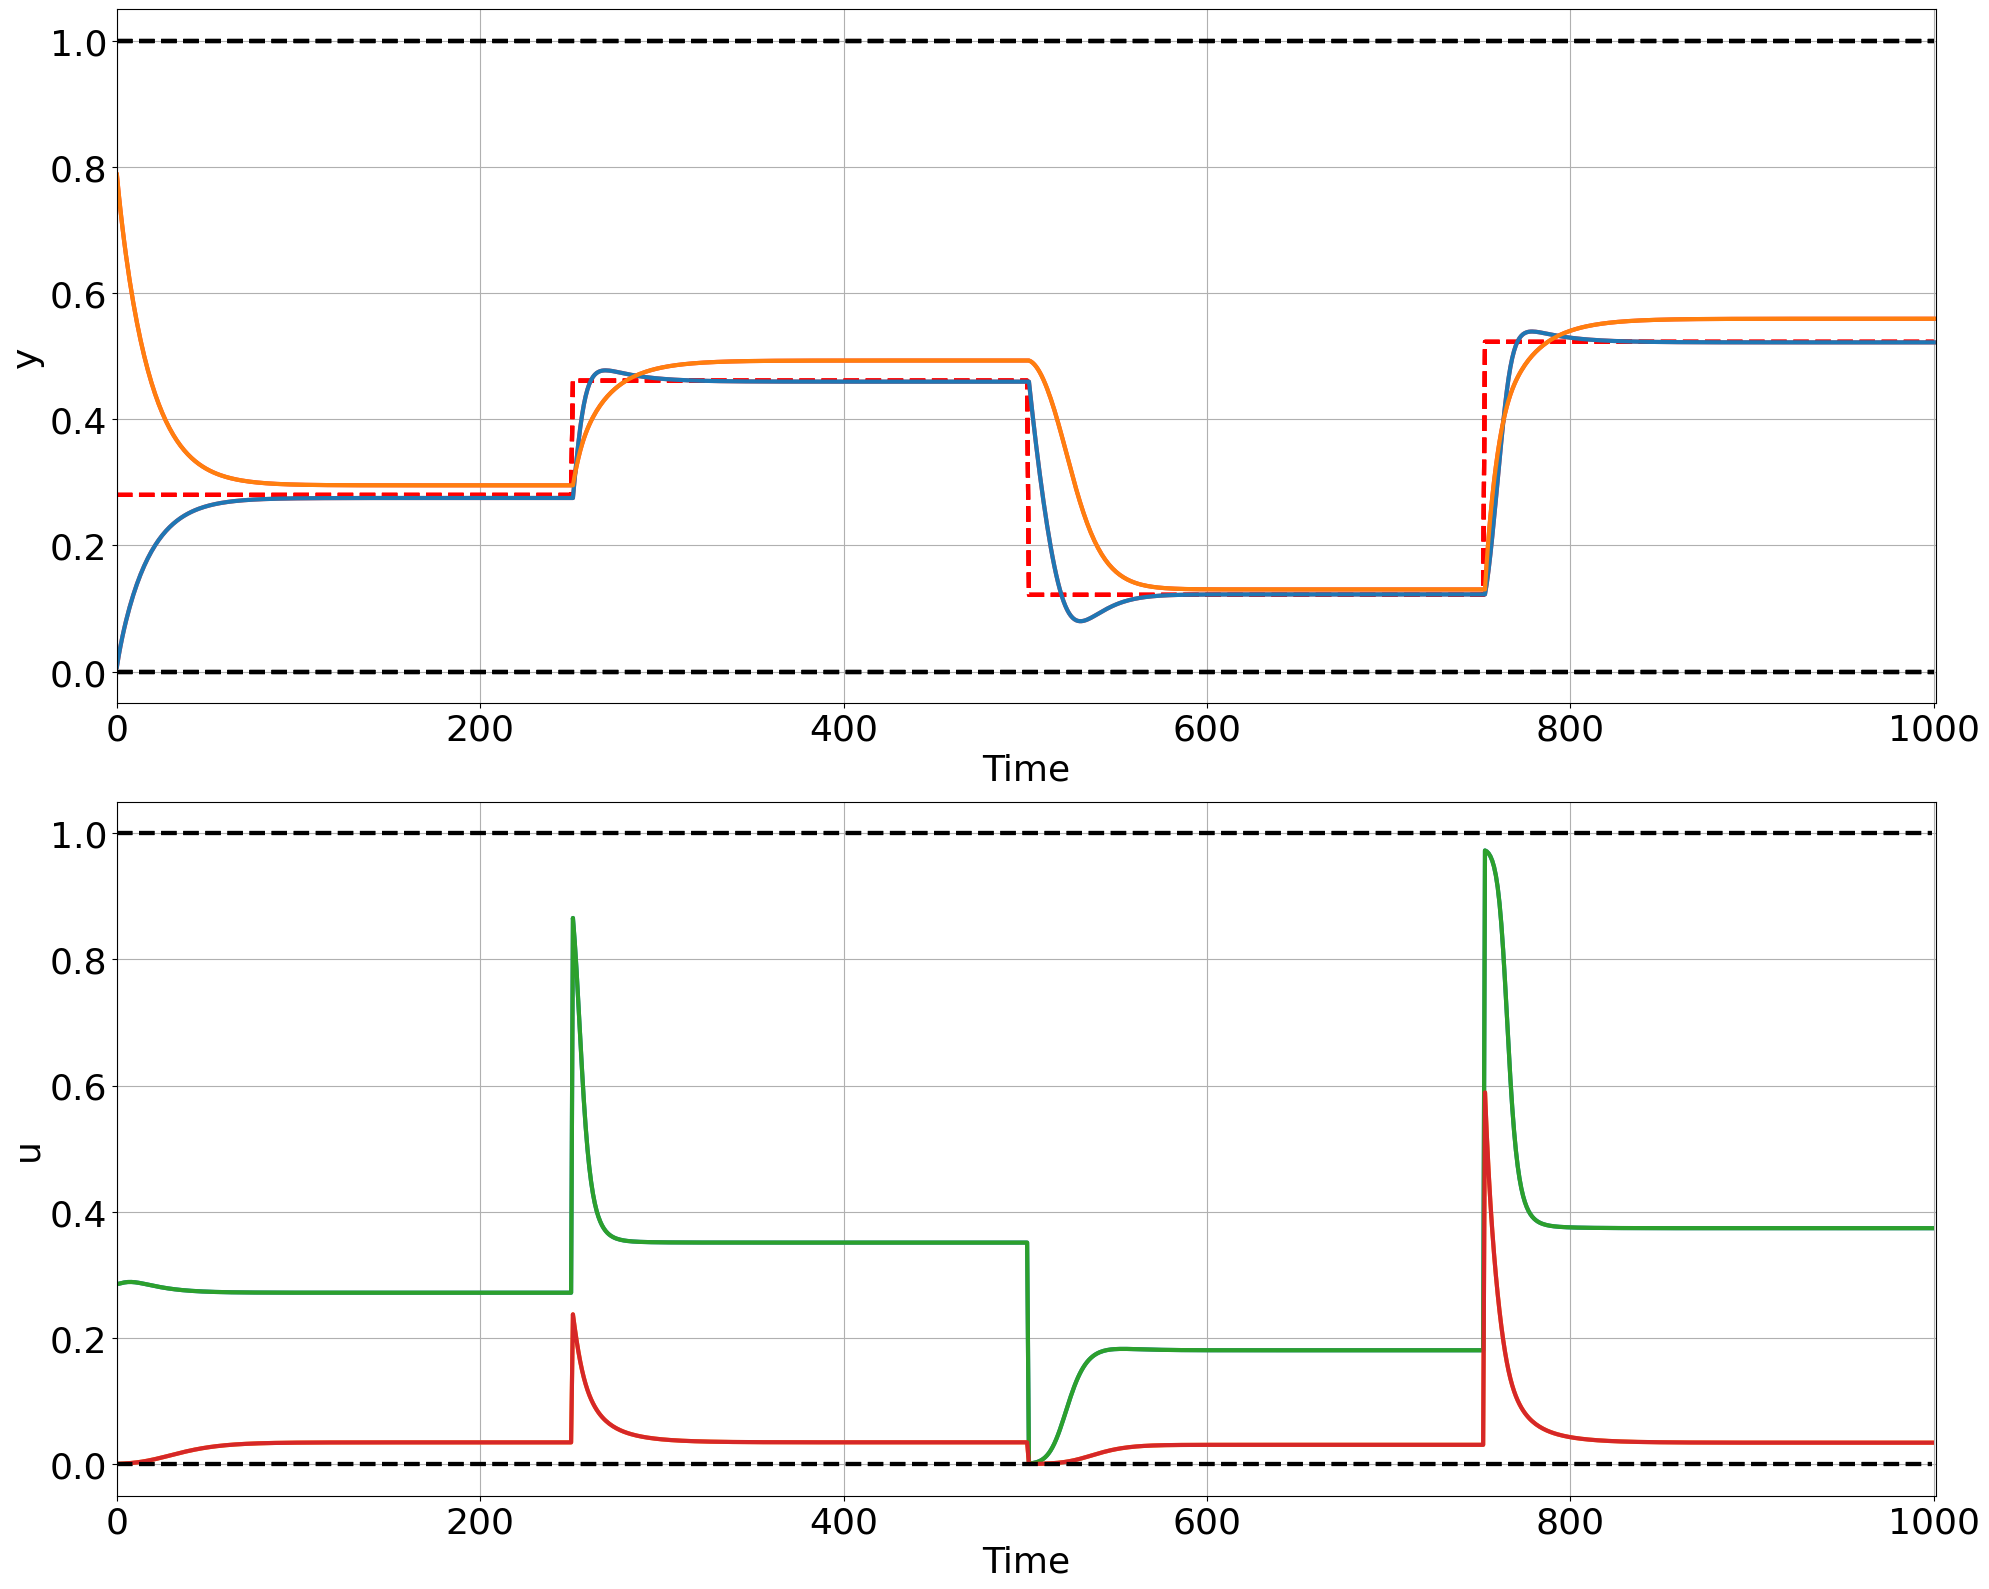

DPC with lower weights on constraints


<Figure size 640x480 with 0 Axes>

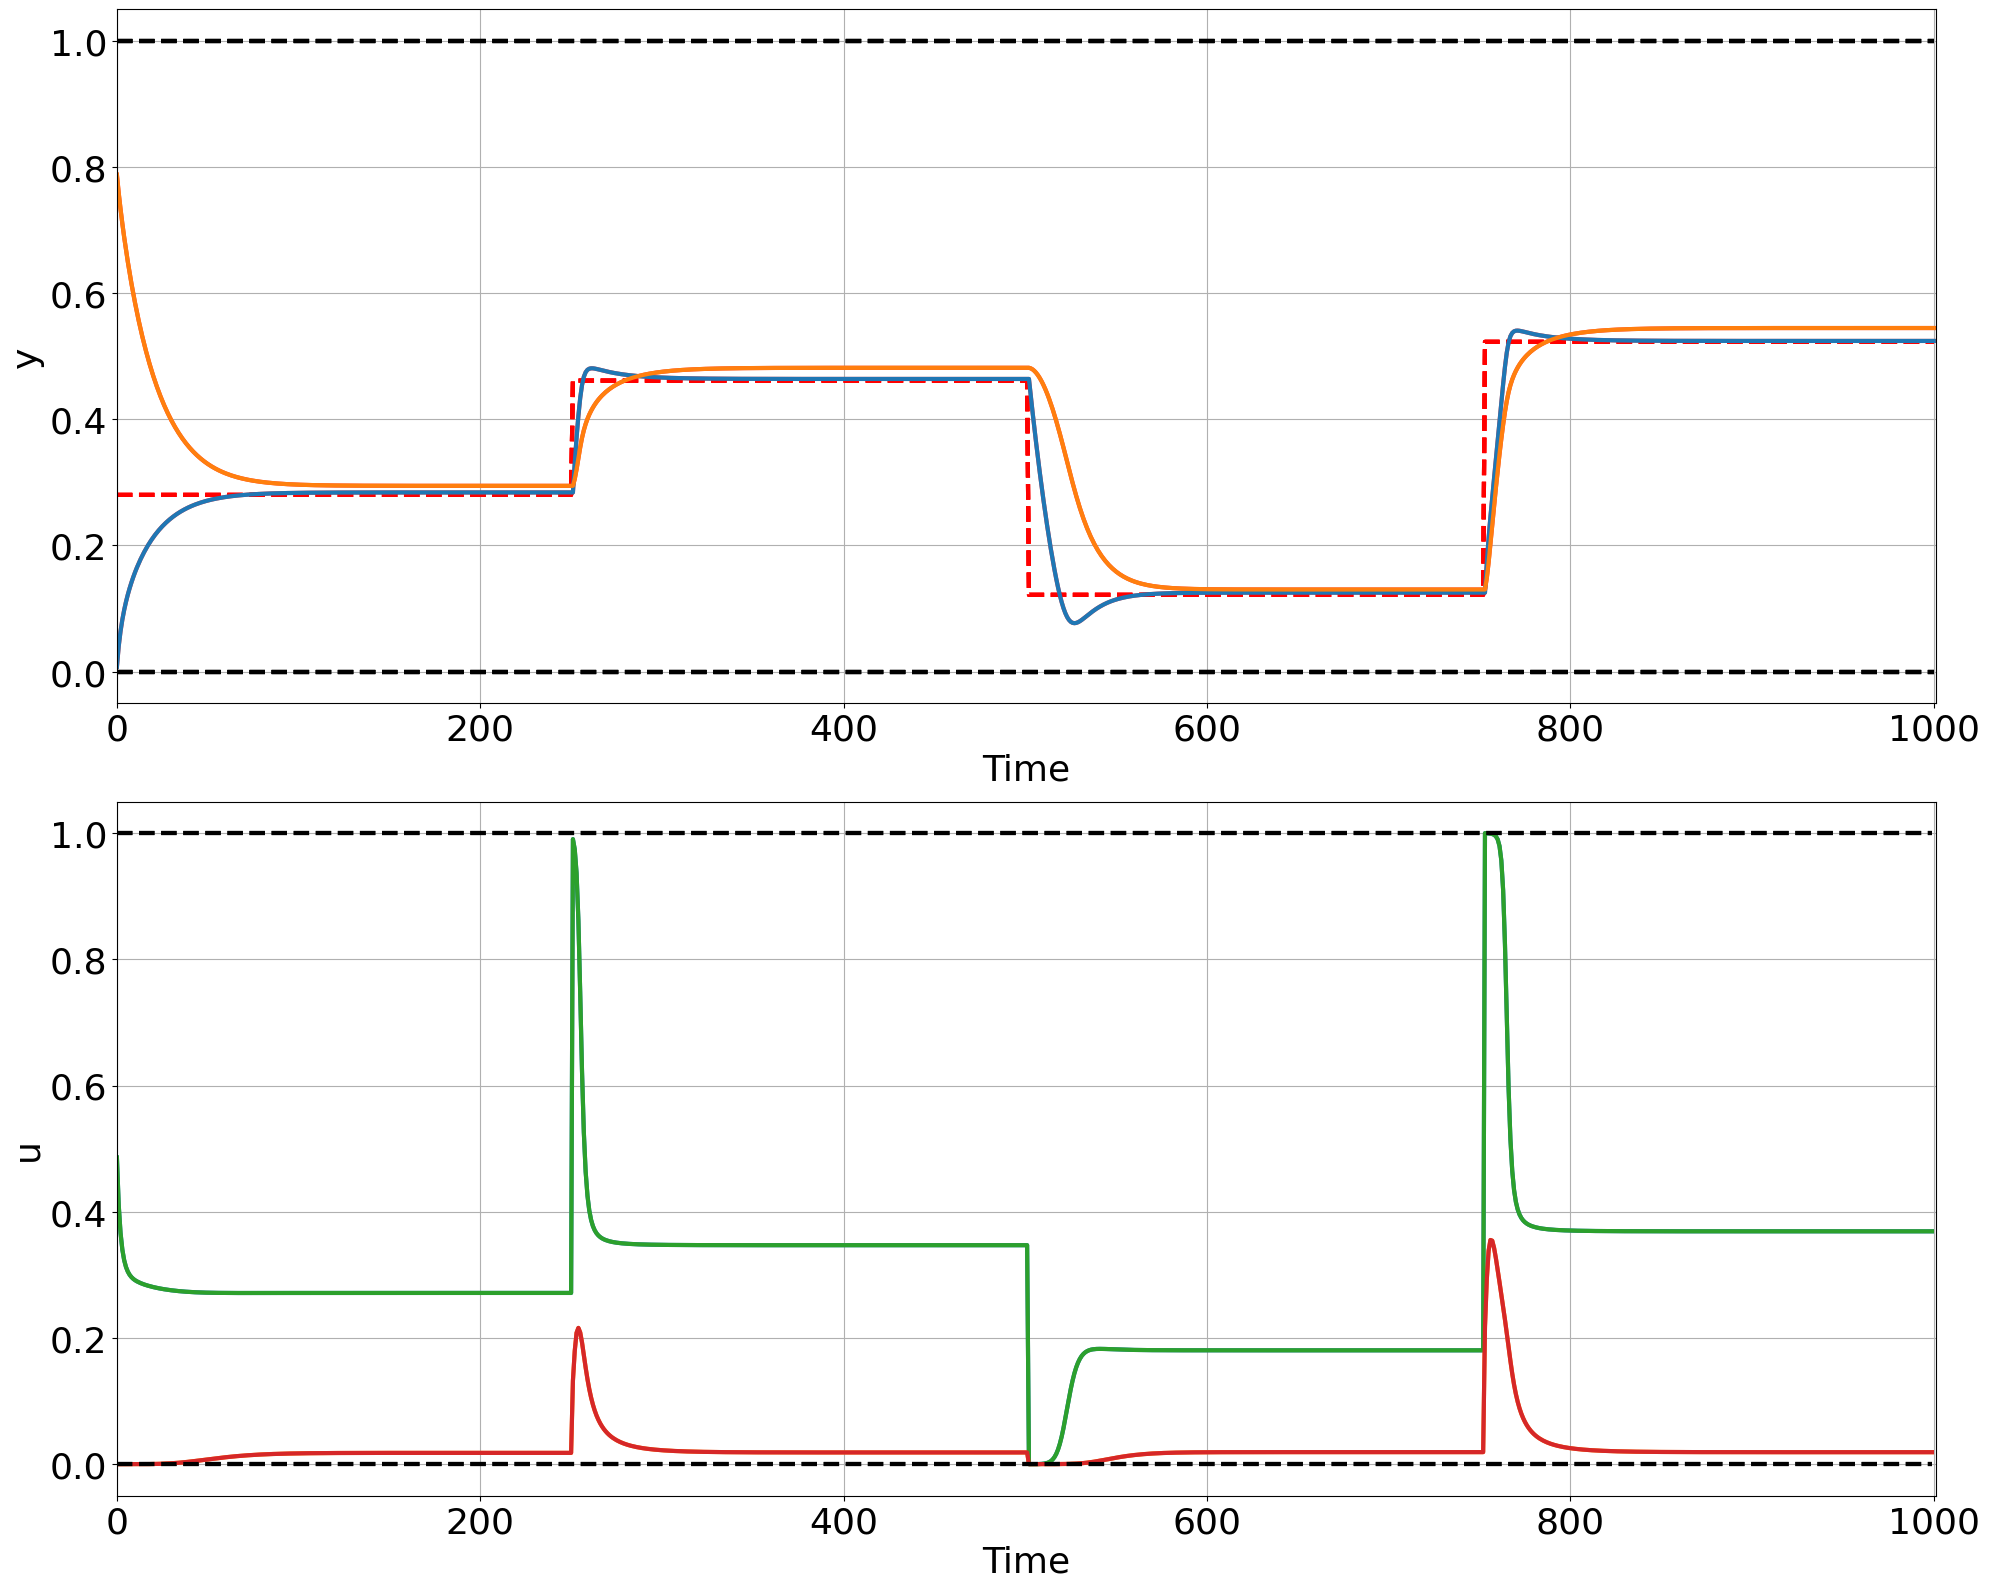

<Figure size 640x480 with 0 Axes>

In [11]:
import matplotlib.pyplot as plt
cl_system.nsteps = nsteps
# perform closed-loop simulation
trajectories = cl_system(data)
# plot closed loop trajectories
print('DPC with original weights on constraints')
pltCL(Y=trajectories['x'].detach().reshape(nsteps + 1, nx),
      R=trajectories['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax,
      figname='cl.png')


cl_system1.nsteps = nsteps
# perform closed-loop simulation
trajectories1 = cl_system1(data)
# plot closed loop trajectories
print('DPC with higher weights on constraints')
pltCL(Y=trajectories1['x'].detach().reshape(nsteps + 1, nx),
      R=trajectories1['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories1['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax,
      figname='cl1.png')

cl_system2.nsteps = nsteps
# perform closed-loop simulation
trajectories2 = cl_system2(data)
# plot closed loop trajectories
print('DPC with lower weights on constraints')
pltCL(Y=trajectories2['x'].detach().reshape(nsteps + 1, nx),
      R=trajectories2['r'].detach().reshape(nsteps + 1, nref),
      U=trajectories2['u'].detach().reshape(nsteps, nu),
      Umin=Umin, Umax=Umax, Ymin=Xmin, Ymax=Xmax,
      figname='cl2.png')

learning: weighting of the constraints/losses influence the control performance - specially stationary control error...